In [1]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [0]:
def preprocess(df):
    df = df.apply(lambda s: re.sub(r'[^a-zA-Z]', ' ', s))
    df = df.apply(lambda s: word_tokenize(s))
    ps = PorterStemmer()
    df = df.apply(lambda s: [ps.stem(word) for word in s])
    lm = WordNetLemmatizer()
    df = df.apply(lambda s: [lm.lemmatize(word) for word in s])
    df = df.apply(lambda s: ' '.join(s))
    return df

In [0]:
def train(model, criterion, optimizer, X_train, Y_train, X_test, Y_test, epochs):
    train_loss, val_loss = [], []
    for e in range(epochs):
        model.train()
        x, y = X_train.float(), Y_train.long()
        optimizer.zero_grad()
        output = model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        t_loss = (loss.item() * x.size(0)) / len(x)

        model.eval()
        x, y = X_test.float(), Y_test.long()
        output = model.forward(x)
        loss = criterion(output, y)
        v_loss = (loss.item() * x.size(0)) / len(x)

        train_loss.append(t_loss)
        val_loss.append(v_loss)
        print(f"Epoch: {e+1} | Training Loss: {t_loss} | Validation Loss: {v_loss}")
        if train_loss[-1] < val_loss[-1] and e >= 10:
            break

    plt.plot(range(1, len(train_loss)+1), train_loss, 'b-', label='Training Loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, 'r-', label='Validation Loss')
    plt.xticks(range(0, 20, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

In [0]:
def test(model, X_val, Y_val):
    model.eval()
    x, y = X_val.float(), Y_val.long()
    output = model.forward(x)
    _, pred = torch.max(output, dim=1)
    correct = pred.eq(y.view_as(pred)).sum()
    print(f"Test Accuracy: {100. * correct / len(X_val):.2f}%")

In [0]:
def main():
    df = pd.read_csv('/content/drive/My Drive/emails.csv')
    df['text'] = preprocess(df['text'])

    cv = CountVectorizer(max_features=10000, stop_words='english')
    sparse_mat = cv.fit_transform(df['text']).toarray()

    l = np.concatenate((sparse_mat, np.array(df['spam']).reshape(len(sparse_mat), 1)), axis=1)
    np.random.shuffle(l)
    X, Y = l[:, :-1], l[:, -1]

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.6)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, train_size=0.2)

    X_train, Y_train = torch.from_numpy(X_train), torch.from_numpy(Y_train)
    X_val, Y_val = torch.from_numpy(X_val), torch.from_numpy(Y_val)
    X_test, Y_test = torch.from_numpy(X_test), torch.from_numpy(Y_test)

    model = Network()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, epochs=30)
    test(model, X_test, Y_test)

Epoch: 1 | Training Loss: 0.6986945271492004 | Validation Loss: 1.323347568511963
Epoch: 2 | Training Loss: 1.1606197357177734 | Validation Loss: 0.3152449429035187
Epoch: 3 | Training Loss: 0.28672167658805847 | Validation Loss: 0.382569819688797
Epoch: 4 | Training Loss: 0.36044737696647644 | Validation Loss: 0.3496294617652893
Epoch: 5 | Training Loss: 0.32448339462280273 | Validation Loss: 0.28345000743865967
Epoch: 6 | Training Loss: 0.2569696009159088 | Validation Loss: 0.23289017379283905
Epoch: 7 | Training Loss: 0.20690582692623138 | Validation Loss: 0.19714170694351196
Epoch: 8 | Training Loss: 0.17282837629318237 | Validation Loss: 0.16599977016448975
Epoch: 9 | Training Loss: 0.14257079362869263 | Validation Loss: 0.13391922414302826
Epoch: 10 | Training Loss: 0.11249832063913345 | Validation Loss: 0.1022711768746376
Epoch: 11 | Training Loss: 0.08304975926876068 | Validation Loss: 0.07524031400680542
Epoch: 12 | Training Loss: 0.05675610527396202 | Validation Loss: 0.05718

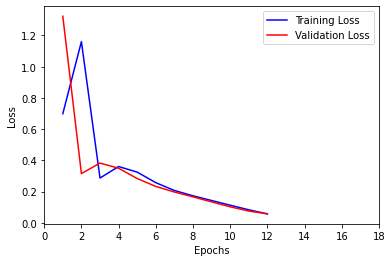

Test Accuracy: 98.47%


In [25]:
if __name__ == '__main__':
    main()